# Getting up to speed with DRL

In this notebook I provide a simple example of implementing a policy gradient Deep Reinforcement Learning algorithm to solve a control problem with continuous state space and discrete action space -- the venerable [CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). You should study the implementation in this notebook in preparation for the laboratory next Wednesday.

This notebook should run in an environment with at least the following packages installed (the gpu version of PyTorch is not mandatory):

     conda create -n DRL -c conda-forge gymnasium pytorch-gpu matplotlib pygame jupyterlab
     
Some background reading to get you started:

1. We will be using the [Gymnasium](https://gymnasium.farama.org/) framework for all of our experiments. This framework provides a consistent interface to a broad range of reinforcement learning environments (including CartPole). You should familiarize yourself with how it works, how environments are specified, how to instantiate them, and how to interact with them.

2. [This excellent blog post](http://karpathy.github.io/2016/05/31/rl/) is a great introduction to policy gradients, where they come from and how they work. Give it a read and I am sure it will help understand better what is going on in this notebook.

## Preliminaries

We start with our standard imports.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

And also some utility functions useful for what comes next.

In [8]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500, device='cpu'):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

## The Policy network

Here I provide a simple policy network which should work with any environment with continuous observations and discrete action spaces. Note how it uses the *specification* of the environment to configure its input and output spaces. 

In [3]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, env.action_space.n)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.relu(self.fc2(s))
        s = F.softmax(self.fc3(s), dim=-1)
        return s

## The `REINFORCE` Algorithm

This is a very simple implementation of the most basic policy gradient DRL algorithm: `REINFORCE`. It is a very direct implementation of the policy gradient update (although I use Adam instead of SGD).

In [21]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, device='cpu', gamma=0.99, num_episodes=10):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-4)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy, device=device)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.005 * returns[0].item() + 0.995 * running_rewards[-1])
        
        # Standardize returns.
        returns = (returns - returns.mean()) / (returns.std() + 1e-6)
        
        # Make an optimization step
        log_probs = log_probs.to(device)
        returns = returns.to(device)
        opt.zero_grad()
        loss = (-log_probs * returns).sum()
        loss.backward()
        opt.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 500:
            policy.eval()
            (obs, _, _, _) = run_episode(env_render, policy, device=device)
            policy.train()
            print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    return running_rewards

In [14]:
# Instantiate a (rendering) CartPole environment.
env_render = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode='human')

# Make a policy network and run a few episodes to see how well random initialization works.
policy = PolicyNet(env_render)
for _ in range(10):
    run_episode(env_render, policy)
    
# If you don't close the environment, the PyGame window stays visible.
env_render.close()

Running reward: -0.05625879287719727
Running reward: 108.88542467847714
Running reward: 128.05200467547613
Running reward: 139.43283453404317
Running reward: 140.38393084747398
Running reward: 155.63457211877974
Running reward: 180.2213547881708
Running reward: 191.55906818694183
Running reward: 172.95683369618487
Running reward: 173.0710610513488
Running reward: 143.43308634616957
Running reward: 182.45018116325917
Running reward: 180.4412817055163
Running reward: 143.5758550795033
Running reward: 183.35572133860904
Running reward: 160.77251295988842
Running reward: 142.47132255961654
Running reward: 142.4460826948849
Running reward: 143.66887781452053
Running reward: 166.61908516912294


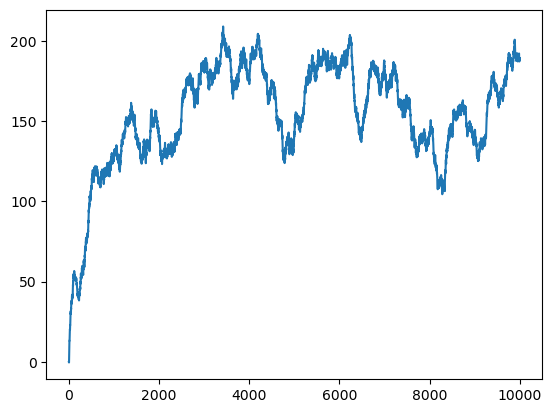

In [23]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

env = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode=None, track_id=1)
env_render = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode='human')

# Make a policy network.
# policy = PolicyNet(env).to(device)

# Train the agent.
plt.plot(reinforce(policy, env, env_render, device=device, num_episodes=10000))

# Close up everything
env_render.close()
env.close()

In [27]:
# And run the final agent for a few episodes.
env_render = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode='human')
for _ in range(10):
    (_, _, _, r) = run_episode(env_render, policy, device=device)
    returns = compute_returns(r, 0.99)
    print(returns[0])
env_render.close()

-41.04792619639561
-31.447408164890653
349.27049770968364
329.22922046572074
312.33465788373735
408.1095267433342
-37.37975214465375
231.56500730024683
337.68132353039067
326.8129595168772


## For your consideration

There are many things that can be improved in this example. Some things you can think about:

1. **Replay**. In the current implementation we execute an episode, and then immediately run an optimization step on all of the steps of the episode. Not only are we using *correlated* samples from a single episode, we are decidedly *not* taking advantage of parallelism via batch gradient descent. Note that `REINFORCE` does **not** require entire trajectories, all we need are the discounted rewards and log probabilities for *individual transitions*.

2. **Exploration**. The model is probably overfitting (or perhaps remaining too *plastic*, which can explain the unstable convergence). Our policy is *always* stochastic in that we sample from the output distribution. It would be interesting to add a temperature parameter to the policy so that we can control this behavior, or even implement a deterministic policy sampler that always selects the action with max probability to evaluate the quality of the learned policy network.

3. **Discount Factor**: The discount factor (default $\gamma = 0.99$) is an important hyperparameter that has an effect on the stability of training. Try different values for $\gamma$ and see how it affects training. Can you think of other ways to stabilize training?